In [1]:
#ABILITà Informatiche
#dati Veneto blocco 21

In [1]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import json
import emcee
import corner
from IPython.display import display, Math
%matplotlib notebook

In [2]:
indata = open('dpc-covid19-ita-regioni.json')
info = json.load(indata)

In [3]:
info[20]

{'data': '2020-02-24T18:00:00',
 'stato': 'ITA',
 'codice_regione': 5,
 'denominazione_regione': 'Veneto',
 'lat': 45.43490485,
 'long': 12.33845213,
 'ricoverati_con_sintomi': 12,
 'terapia_intensiva': 4,
 'totale_ospedalizzati': 16,
 'isolamento_domiciliare': 16,
 'totale_positivi': 32,
 'variazione_totale_positivi': 0,
 'nuovi_positivi': 32,
 'dimessi_guariti': 0,
 'deceduti': 1,
 'casi_da_sospetto_diagnostico': None,
 'casi_da_screening': None,
 'totale_casi': 33,
 'tamponi': 2200,
 'casi_testati': None,
 'note': None,
 'ingressi_terapia_intensiva': None,
 'note_test': None,
 'note_casi': None,
 'totale_positivi_test_molecolare': None,
 'totale_positivi_test_antigenico_rapido': None,
 'tamponi_test_molecolare': None,
 'tamponi_test_antigenico_rapido': None,
 'codice_nuts_1': None,
 'codice_nuts_2': None}

In [4]:
len(info)

21252

In [5]:
data_tot = []
casi_tot = []

for i in range(1012):
    data_tot.append(info[20 + i*21]['data'])
    casi_tot.append(info[20 + i*21]['totale_casi'])

<IPython.core.display.Javascript object>


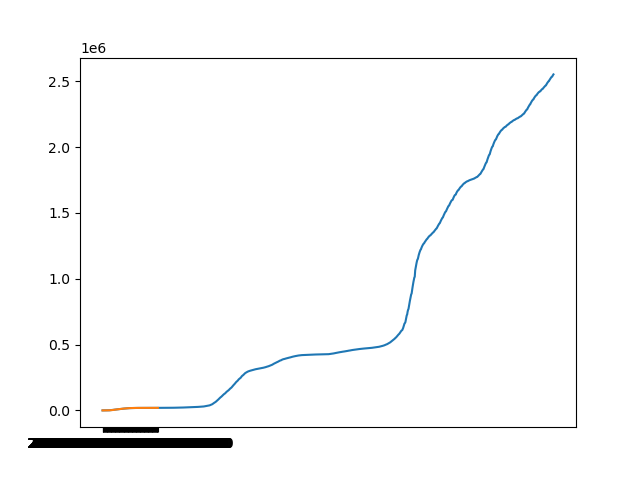

In [6]:
plt.figure()
plt.plot(casi_tot)

In [7]:
data = []
casi = []
N = 125

for i in range(N):
    data.append(info[20 + i*21]['data'])
    casi.append(info[20 + i*21]['totale_casi'])
    
plt.plot(data, casi)

casi_dif = np.zeros(N-1)
for t in range(N-1):
        casi_dif[t] = casi[t+1] - casi[t]

In [8]:
#funzione di gompertz

In [9]:
def gompertz(N, t0, ni, b):
    '''
    calcolo della funzione di gompertz per N punti con t0 tempo di inizio, ni plateau della popolazione/dimensione popolazione, 
    b rate di crescita iniziale e n0 popolazione iniziale
    output funzione di gompertz e funzione di gompertz differenziale
    '''
    gomp = np.zeros(N)
    k = np.log(ni)
    for t in range(N):
        gomp[t] = np.exp( k * ( 1 - np.exp( -b * (t-t0) ) ) )

    gomp_diff = np.zeros(N-1)
    for t in range(N-1):
            gomp_diff[t] = gomp[t+1] - gomp[t]
            
    return gomp, gomp_diff

<IPython.core.display.Javascript object>


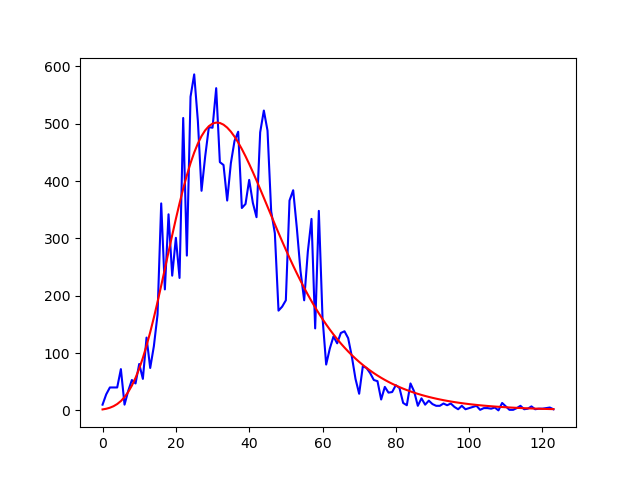

In [10]:
#prova con casi
t0 = -1
b = 0.07
ni = 19500

prova, diff = gompertz(N, t0, ni, b)

dati_casi = [x for x in casi_dif]

plt.figure()
plt.plot(dati_casi, color='blue')
plt.plot(diff, color='red')

In [11]:
#poisson likelihood

In [12]:
def log_likelihood(dati, predizione):
    '''
    calcolo del logaritmo poisson-likelihood per i dati usando come modello predizione (entrambi array) 
    '''
    predizione = [abs(x) + .02 for x in predizione]
    # log(likelihood) = L
    L = np.sum(np.log(predizione)*dati - predizione )
        
    # non c'è fattoriale perchè non serve per minimizzare (log(dati[i]!) non dipende dal modello)
    return L 

<IPython.core.display.Javascript object>


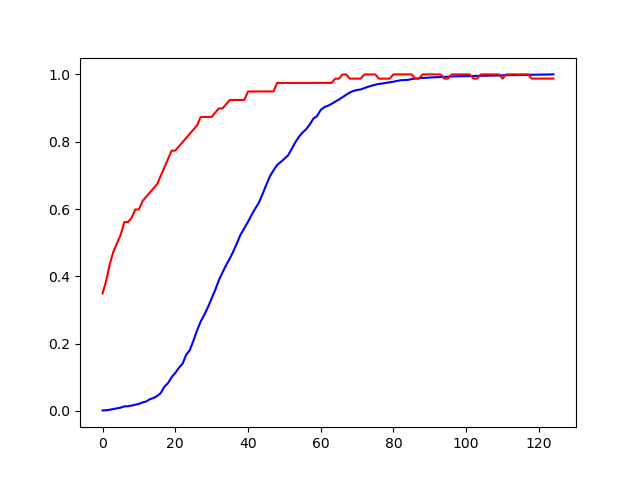

In [13]:
#prova casi
log_like = lambda *args: -log_likelihood(*args)

stima = prova
dati = [x for x in casi]

sol = minimize(log_like, stima, dati)

dati_nor = [x/max(dati) for x in dati]

sol_nor = sol.x/max(sol.x)

plt.figure()
plt.plot(dati_nor, color='blue')
plt.plot(sol_nor, color='red')

In [14]:
#emcee guida:https://emcee.readthedocs.io/en/stable/tutorials/line/

In [15]:
def log_likelihood_gompertz(theta, dati):
    '''
    calcolo del logaritmo poisson-likelihood per i dati (array) usando come modello la funzione di gompertz (vedi fun gompertz) 
    '''
    t0, ni, b = theta
    N = len(dati) + 1
    modello, dif = gompertz(N, t0, ni, b)
    
    # -log(likelihood) = L
    L = log_likelihood(dati, dif)   
    # non c'è fattoriale perchè non serve per minimizzare (log(dati[i]!) non dipende dal modello)
    
    return L

In [16]:
#np.random.seed(7)
t0 = -np.random.randint(0, 5)
ni = max(casi) + 500 * np.random.uniform(-1,1)
b = np.random.uniform()

modello, diff_modello = gompertz(N, t0, ni, b)

'''
print(t0, ni, b)
plt.figure()
#plt.plot(modello)
plt.plot(diff_modello)
'''

'\nprint(t0, ni, b)\nplt.figure()\n#plt.plot(modello)\nplt.plot(diff_modello)\n'

[-1.00000000e+00  9.07567926e+02  5.44249472e-02]
[-2.43666508e+00  1.92750036e+04  6.81191997e-02]


<IPython.core.display.Javascript object>


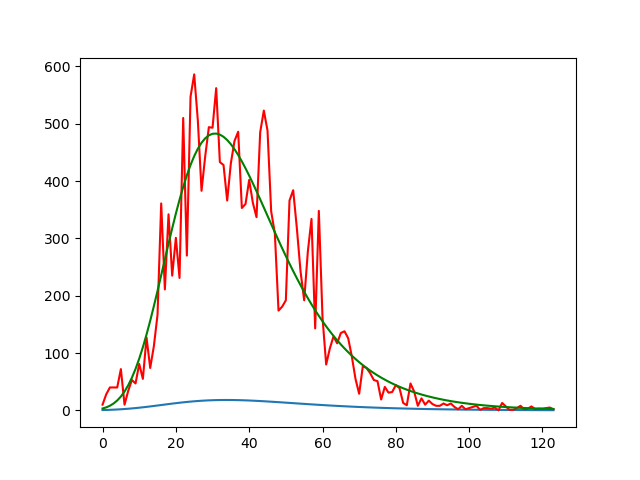

In [17]:
nll = lambda *args: -log_likelihood_gompertz(*args)
dati = [x for x in casi_dif]

t0 = -np.random.randint(0, 5)
ni = max(dati) + 500 * np.random.uniform(-0.9,0.9)
b = np.random.uniform(0.05, 0.1)
parametri = np.array([t0, ni, b])

soln = minimize(nll, parametri, args=(dati))
print(parametri)
print(soln.x)
t01, ni1, b1 = soln.x

modello, diff_modello = gompertz(N, t0, ni, b)
modello1, diff_modello1 = gompertz(N, t01, ni1, b1)

plt.figure()
plt.plot(diff_modello)
plt.plot(dati, color='red')
plt.plot(diff_modello1, color='green')

In [19]:
#distribuzione prob parametri è costante, lo è anche il logaritmo, lo si ignora per minimizzazione

def log_prior(theta):
    t0, ni, b = theta
    if t0 <= 0 and ni > 0.0 and 0.0 < b < 1.0:
        return 0.0
    return -np.inf
    

#log_probability = log_likelihood_gompertz + log_prior(=cost) = log_likelihood_gompertz
'''
def log_probability(theta, dati):
    lp = log_prior(theta)
    return lp + log_likelihood_gompertz(theta, dati)
'''

def log_probability(theta, dati):
    lp = log_prior(theta)
    ll = log_likelihood_gompertz(theta, dati)
    if not np.isfinite(lp):
        return -np.inf
    return (lp + ll)

#log_probability = log_likelihood_gompertz(parametri, dati)

In [20]:
#simulazione
dati_in = [x for x in casi_dif]
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=([dati_in]))
sampler.run_mcmc(pos, 500, progress=True);

100%|██████████| 500/500 [00:10<00:00, 49.47it/s]


<IPython.core.display.Javascript object>


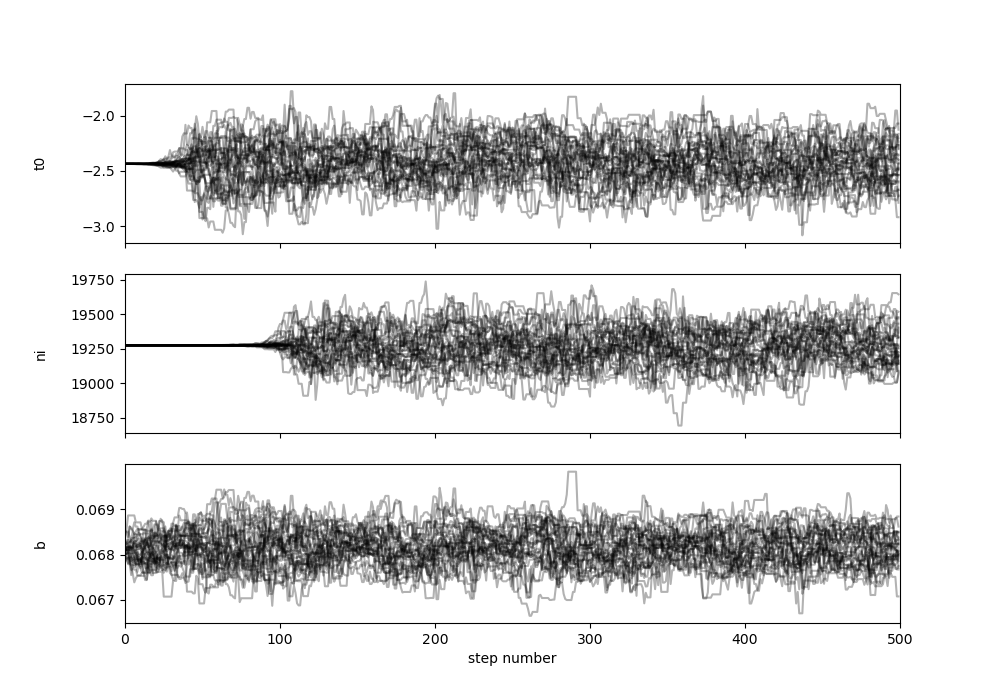

In [21]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["t0", "ni", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

<IPython.core.display.Javascript object>


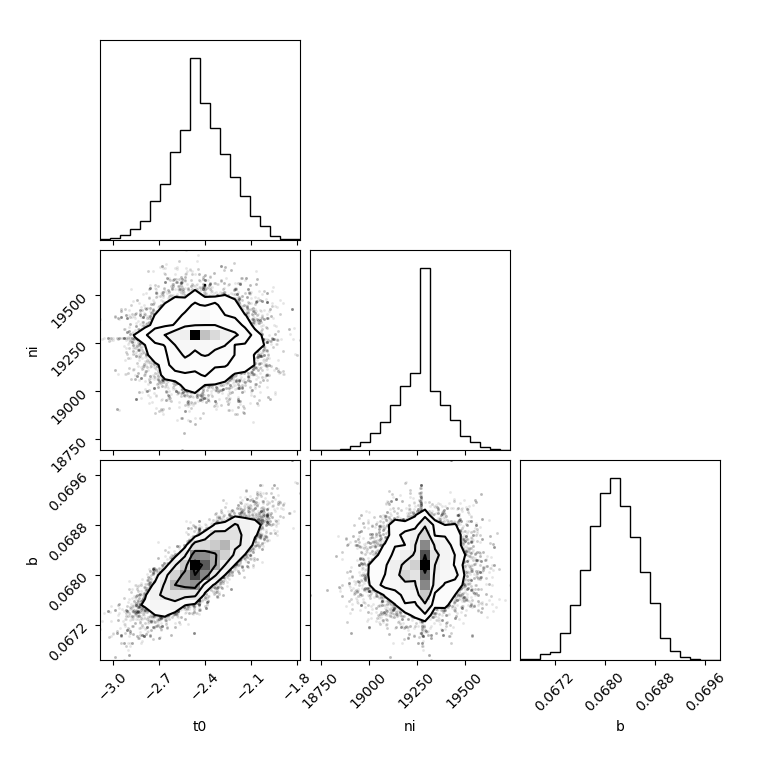

In [22]:
flat_samples = sampler.get_chain(flat='True')
fig = corner.corner(flat_samples, labels=labels);